In [15]:
import sys
import os
import datetime
print(os.environ['EXEC'])
os.chdir(os.environ['EXEC'])
sys.path.append('/home/dominicyang/software/prescient/release/Prescient_1.0')
print(sys.path)

/home/dominicyang/software/prescient/release/Prescient_1.0/exec
['', '/usr/local/lib/python3.5/dist-packages/networkx-2.0-py3.5.egg', '/usr/local/lib/python3.5/dist-packages/python_dateutil-2.6.1-py3.5.egg', '/usr/local/lib/python3.5/dist-packages/PyUtilib-5.5.1-py3.5.egg', '/usr/local/lib/python3.5/dist-packages/Pyomo-5.2-py3.5.egg', '/usr/local/lib/python3.5/dist-packages/decorator-4.1.2-py3.5.egg', '/usr/local/lib/python3.5/dist-packages/nose-1.3.7-py3.5.egg', '/usr/local/lib/python3.5/dist-packages/ply-3.10-py3.5.egg', '/usr/local/lib/python3.5/dist-packages/appdirs-1.4.3-py3.5.egg', '/home/dominicyang/software/prescient/release/Prescient_2.0', '/usr/lib/python35.zip', '/usr/lib/python3.5', '/usr/lib/python3.5/plat-x86_64-linux-gnu', '/usr/lib/python3.5/lib-dynload', '/home/dominicyang/.local/lib/python3.5/site-packages', '/usr/local/lib/python3.5/dist-packages', '/usr/lib/python3/dist-packages', '/home/dominicyang/.local/lib/python3.5/site-packages/IPython/extensions', '/home/domi

In [16]:
import MasterOptions

args = ['--model-directory=prescient_test',
'--ruc-horizon=48',
'--pyspgen-base-file=prescient_test/simple_nostorage_skeleton.dat',
'--traceback',
'--loads-dps-cuts-filename=prescient_test/MeanOnly.dat',
'--loads-input-directory=prescient_test/',
'--loads-input-filename=CAiso-TAC_demand_12-15.csv',
'--load-scaling-factor=0.045',
'--run-populator',
'--scenarios-populate-datesfile=prescient_test/BPA_Scenario_Dates.dat',
'--data-to-fit=rolling',
'--cutpoints-names-filename=prescient_test/cpts_names.dat',
'--single-category-width=0.4',
'--output-directory=prescient_test/bpa_output',
'--ruc-horizon=48',
'--sources-file=prescient_test/SC1_source.csv',
'--error-distribution-domain=3,max',
'--traceback',
'--snapshot-interval=60',
'--output-solver-log',
'--traceback',                                                                     
'--snapshot-interval=60',                                                          
'--output-solver-log',                                                             
'--categorize-by-shape',                                                           
'--lower-medium-bound=-10000',                                                     
'--upper-medium-bound=10000',
'--disable-interpolation',
'--derivative-bounds=0.3,0.7']

options_parser, _ = MasterOptions.construct_options_parser()
(options, _) = options_parser.parse_args(args)

In [17]:
options

<Values at 0x7fd3871d1780: {'static_categories': '', 'recompute_probabilities_using_copula': None, 'plot_forecast_distribution': False, 'output_directory': 'prescient_test/bpa_output', 'sced_solver_options': [], 'threetier_working_directory': '../data/3Tier', 'upperbound_filename': '', 'forecasts_for_comparison_input_filename': '', 'errors_directory': 'errors_directory', 'plot_categorized_error_percentage_distribution': False, 'negative_power': False, 'MSSimulator_mipgap': 0.1, 'start_date': '01-01-2011', 'snapshot_interval': 60, 'wind_actuals_input_filename': '', 'epifit2d_off': True, 'pyspgen_base_file': 'prescient_test/simple_nostorage_skeleton.dat', 'ruc_execution_hour': 20, 'pyspgen_gendat_filename': 'gen.dat', 'plot_forecast': False, 'non_negativity_constraint_distributions': 0, 'forecasts_input_filename': '', 'run_deterministic': False, 'single_category_width': 0.4, 'write_categorized_error_percentage_distribution': False, 'write_directory': '', 'scenario_date': None, 'scatter_p

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib notebook

In [19]:
# This parses out the source file, taken from prescient.populate

import csv

source_names=[]                                                             
source_directory_names = []                                                 
source_file_paths=[]                                                        
source_cutpoint_patterns=[]                                                 
source_error_dist=[]                                                        
source_types=[]                                                             
source_file_paths_forecasts=[]                                              
source_upper_bounds=[]                                                      
if options.categorize_by_vendor_pi_width:                                   
    source_file_paths_vendor_pi_min = []                                    
    source_file_paths_vendor_pi_max = []                                    

# # intaking source csv # # Aug 2015: dlw askes why also in pyspgen.py?     
if not os.path.exists(options.sources_file):                                
    raise RuntimeError("***ERROR: The sources file %s either does not exist" % options.sources_file)
source_csv = csv.reader(open(options.sources_file, 'rU'))                   
for sline in source_csv:                                                    
    if len(sline) == 0:                                                     
        continue                                                            
    elif sline[0][0] == '#':                                                
        continue                                                            
    elif sline[0] == 'end':                                                 
        break                                                               
    source_names.append(sline[0])                                           
    source_directory_names.append(sline[1])                                 
    source_file_paths.append(sline[2])                                      
    source_cutpoint_patterns.append(sline[3])                               
    source_error_dist.append(sline[4])                                      
    source_types.append(sline[5])                                           
    source_file_paths_forecasts.append(sline[6])                            
    # HEY! We don't process the bus name, for some reason.                  
    source_upper_bounds.append(sline[8])                                    
    if options.categorize_by_vendor_pi_width:                               
        source_file_paths_vendor_pi_min.append(sline[9])                    
        source_file_paths_vendor_pi_max.append(sline[10])                   
    if len(source_names) != len(set(source_names)):                         
        print("***WARNING: SOURCE NAMES SHOULD BE UNIQUE")                  
source_options = [[]]*len(source_names)                                     

for l in range(len(source_names)):                                          
    if source_file_paths_forecasts[l] == '':                                
        source_file_paths_forecasts[l] = source_file_paths[l]               
            
options.working_directory = options.output_directory + os.sep + "outdir"    
options.fitting_directory = options.output_directory + os.sep + "fitdir"    
options.errors_directory = options.output_directory + os.sep + options.errors_directory
options.scenario_directory = options.output_directory + os.sep + "scendir"            
options.pyspgen_output_directory = options.output_directory + os.sep + "pyspdir"
options.pyspgen_output_directory_twostage = options.output_directory + os.sep + "pyspdir_twostage"
options.pyspgen_output_directory_multistage = options.output_directory + os.sep + "pyspdir_multistage"
options.source_types = source_types                                                              
options.scengen_num_time_periods = options.ruc_horizon                      
options.pyspngen_num_time_periods = options.ruc_horizon 

/home/dominicyang/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: DeprecationWarning: 'U' mode is deprecated


In [20]:
options.scenarios_populate_datesfile

'prescient_test/BPA_Scenario_Dates.dat'

In [21]:
import ScenGen
DateRangesData = ScenGen.workflow.LoadData.LoadDateRangesData(options.scenarios_populate_datesfile)

date_string = '2013-07-11'
scenario_day = pd.Timestamp(date_string)

date1 = DateRangesData['Period2'][2][0][0]
date1

datetime.date(2013, 7, 11)

In [22]:
date = this_date = date1
# What is this even needed for?
with open(options.output_directory + os.sep + 'tmp_' +      
                                      this_date.isoformat() + '.tmp', 'w') as f:
                        print('name 2 3 4 ' + this_date.isoformat() + ' ' + this_date.isoformat(), file=f)

In [23]:
source = source_names[0]
print(source)

Wind


In [24]:
source_types

['wind']

In [25]:
sourcedir = options.output_directory + os.sep + source
options.forecasts_actuals_output_directory = sourcedir
options.forecasts_actuals_input_directory = source_directory_names[0]
options.forecasts_input_filename = source_file_paths_forecasts[0]
options.actuals_input_filename = source_file_paths[0]
if options.categorize_by_vendor_pi_width:
    options.vendor_pi_lower_limit_input_filename = source_file_paths_vendor_pi_min[0]
    options.vendor_pi_upper_limit_input_filename = source_file_paths_vendor_pi_max[0]
options.cutpoints_dps_params_filename = source_cutpoint_patterns[0]

if source_upper_bounds[0] is not None and source_upper_bounds[0] != '':
    FN = os.path.join(source_directory_names[0], source_upper_bounds[0])
else:
    FN = ''
if source_types[0] == "solar":
    options.diurnal_pattern_filename = FN
else:                                                   
    options.upperbound_filename = FN                    
options.error_distribution_domain = source_error_dist[0]
options.scenarios_populate_datesfile = \
    options.output_directory + os.sep + 'tmp_' + this_date.isoformat() + '.tmp'
options.path_dependent_cutpoints = 1
options.get_error_correlation = 0
options.DayClone = 'CopyLast'                           
options.data_to_fit = options.data_to_fit             
ForecastUpdates = False
datafile_forecast = \
    options.forecasts_actuals_input_directory + os.sep + options.forecasts_input_filename


In [26]:
def print_options(options):
    for option in sorted(options.__dict__):
        print(option, ':', getattr(options, option))
print_options(options)

DayClone : CopyLast
L1Linf_solver : gurobi
L2Norm_solver : gurobi
MSSim_Ruc_solver_tee : False
MSSim_Sced_solver_tee : False
MSSim_adjust_load : False
MSSim_adjust_renewables : False
MSSim_initial_conditions_from_file : None
MSSim_num_days : 1
MSSim_perfect_updates_scenarios : False
MSSim_plotCharts : False
MSSim_plot_CommitmentCharts : False
MSSim_plot_adjusted_scenarios : False
MSSim_pprint_RUC : False
MSSim_run_ID_deterministic_for_everymodel : False
MSSim_start_date : None
MSSim_use_adjusted_scenarios : False
MSSim_use_same_model_for_stage2 : False
MSSim_write_RUC_lp_files : False
MSSimulator_RUC_TimeLimit : None
MSSimulator_mipgap : 0.1
actual_outage_scenario : 0
actual_wind_scenario : 0
actuals_input_filename : 2012-2013_BPA_forecasts_actuals.csv
alpha_prediction_interval : None
categorize_by_derivative_behaviour : False
categorize_by_first_difference_behaviour : False
categorize_by_shape : True
categorize_by_vendor_agreement : False
categorize_by_vendor_pi_width : False
commitme

In [27]:
import ScenGen.workflow.ProcessForecastsActuals as pfa
import ScenGen.workflow.DiurnalPattern as dp
errors,forecasts, actuals, ScenDateRanges, upper_bounds, lower_bounds, vendor_pi_width = \
    pfa.read_data_old_method(options)

Reading forecasts from file: prescient_test/2012-2013_BPA_forecasts_actuals.csv
Reading actuals from file: prescient_test/2012-2013_BPA_forecasts_actuals.csv
Number of forecast entries read: 12404
Number of actual entries read: 12404
Reading dr (weights, number of segments and date ranges) data from file prescient_test/bpa_output/tmp_2013-07-11.tmp
Reading upper bound file=prescient_test/manual_ub.dat


<IPython.core.display.Javascript object>


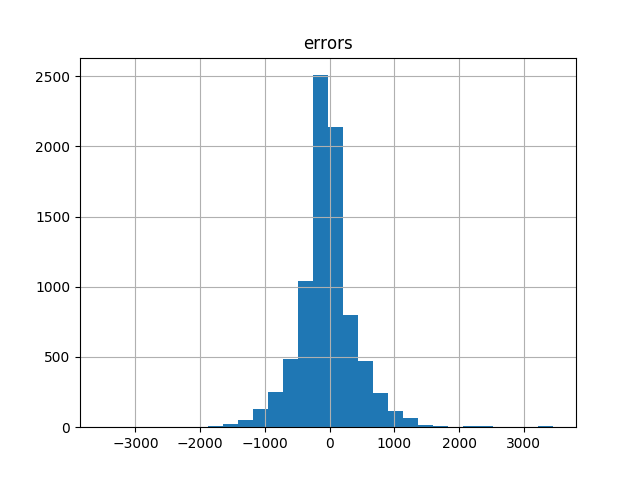

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd3c19a7c88>]], dtype=object)

In [28]:
error_series = pd.Series(errors)[:scenario_day-datetime.timedelta(hours=1)]

forecast_series = pd.Series(forecasts)
actual_series = pd.Series(actuals)
df = pd.DataFrame()
df['errors'] = error_series
df['forecasts'] = forecast_series
df['actuals'] = actual_series

df.sort_index()

df.hist('errors', bins=30)

<IPython.core.display.Javascript object>


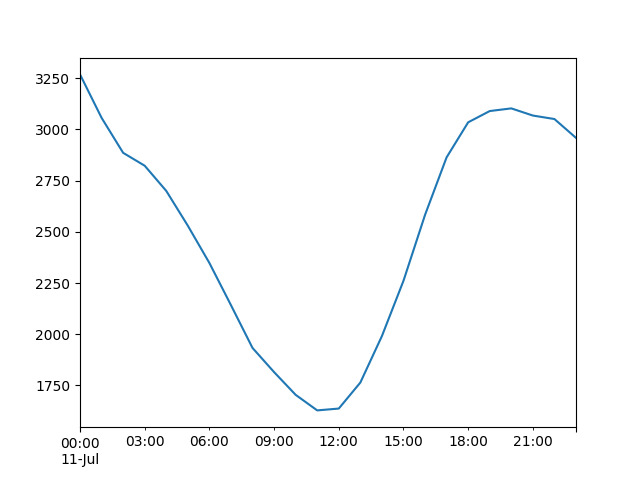

In [29]:
plt.figure()
forecast_series[date_string].plot()

In [30]:
df

,errors,forecasts,actuals
2012-06-02 00:00:00,-524.0,2208.0,1684.0
2012-06-02 01:00:00,-194.0,2248.0,2054.0
2012-06-02 02:00:00,-137.0,2303.0,2166.0
2012-06-02 03:00:00,-422.0,2348.0,1926.0
2012-06-02 04:00:00,-449.0,2377.0,1928.0
2012-06-02 05:00:00,-272.0,2349.0,2077.0
2012-06-02 06:00:00,-361.0,2300.0,1939.0
2012-06-02 07:00:00,-249.0,2248.0,1999.0
2012-06-02 08:00:00,-513.0,2312.0,1799.0
2012-06-02 09:00:00,-301.0,2471.0,2170.0


<IPython.core.display.Javascript object>


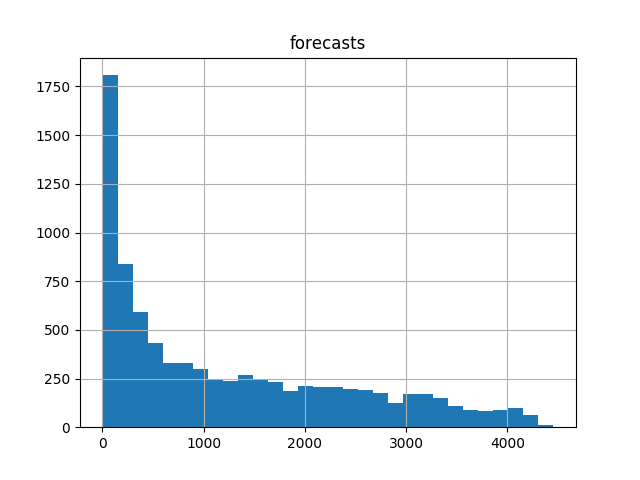

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd387399dd8>]], dtype=object)

In [31]:
df.hist('forecasts', bins=30)

In [32]:
forecasts, hist_deriv, new_forecast, new_deriv, _, _, _, _ \
= pfa.Make_appropriate_working_forecastdicts(options, forecasts, forecasts, this_date, errors)



Evaluating derivatives
  Computing episplines for day=2012-06-02
  Computing episplines for day=2012-06-03
  Computing episplines for day=2012-06-04
  Computing episplines for day=2012-06-06
  Computing episplines for day=2012-06-07
  Computing episplines for day=2012-06-18
  Computing episplines for day=2012-06-20
  Computing episplines for day=2012-06-21
  Computing episplines for day=2012-06-27
  Computing episplines for day=2012-07-05
  Computing episplines for day=2012-07-06
  Computing episplines for day=2012-07-11
  Computing episplines for day=2012-07-20
  Computing episplines for day=2012-07-21
  Computing episplines for day=2012-07-24
  Computing episplines for day=2012-07-25
  Computing episplines for day=2012-07-27
  Computing episplines for day=2012-07-28
  Computing episplines for day=2012-07-29
  Computing episplines for day=2012-07-30
  Computing episplines for day=2012-07-31
  Computing episplines for day=2012-08-01
  Computing episplines for day=2012-08-02
  Computin

  Computing episplines for day=2013-02-03
  Computing episplines for day=2013-02-04
  Computing episplines for day=2013-02-05
  Computing episplines for day=2013-02-06
  Computing episplines for day=2013-02-07
  Computing episplines for day=2013-02-08
  Computing episplines for day=2013-02-09
  Computing episplines for day=2013-02-10
  Computing episplines for day=2013-02-11
  Computing episplines for day=2013-02-12
  Computing episplines for day=2013-02-13
  Computing episplines for day=2013-02-14
  Computing episplines for day=2013-02-15
  Computing episplines for day=2013-02-16
  Computing episplines for day=2013-02-17
  Computing episplines for day=2013-02-18
  Computing episplines for day=2013-02-19
  Computing episplines for day=2013-02-20
  Computing episplines for day=2013-02-21
  Computing episplines for day=2013-02-22
  Computing episplines for day=2013-02-23
  Computing episplines for day=2013-02-24
  Computing episplines for day=2013-02-25
  Computing episplines for day=201

In [33]:
forecasts

{datetime.datetime(2013, 5, 21, 12, 0): 2958.0,
 datetime.datetime(2012, 8, 30, 14, 0): 81.0,
 datetime.datetime(2012, 8, 14, 15, 0): 2644.0,
 datetime.datetime(2012, 10, 12, 0, 0): 100.0,
 datetime.datetime(2012, 10, 11, 3, 0): 277.0,
 datetime.datetime(2012, 12, 18, 16, 0): 2078.0,
 datetime.datetime(2012, 9, 7, 0, 0): 230.0,
 datetime.datetime(2013, 6, 17, 7, 0): 2054.0,
 datetime.datetime(2012, 9, 2, 20, 0): 2129.0,
 datetime.datetime(2012, 11, 24, 15, 0): 1200.0,
 datetime.datetime(2013, 4, 24, 21, 0): 276.0,
 datetime.datetime(2012, 8, 14, 3, 0): 1407.0,
 datetime.datetime(2012, 8, 23, 15, 0): 3579.0,
 datetime.datetime(2012, 7, 28, 4, 0): 2021.0,
 datetime.datetime(2012, 9, 18, 9, 0): 71.0,
 datetime.datetime(2013, 4, 22, 0, 0): 1139.0,
 datetime.datetime(2013, 5, 24, 0, 0): 906.0,
 datetime.datetime(2012, 11, 1, 22, 0): 1706.0,
 datetime.datetime(2013, 3, 17, 19, 0): 3884.0,
 datetime.datetime(2013, 2, 13, 15, 0): 3626.0,
 datetime.datetime(2012, 12, 2, 5, 0): 2288.0,
 datetime

In [34]:
hist_deriv

{datetime.datetime(2013, 5, 21, 12, 0): -120.87227219627003,
 datetime.datetime(2012, 8, 30, 14, 0): 38.814576453475524,
 datetime.datetime(2012, 8, 14, 15, 0): 316.4674986812074,
 datetime.datetime(2012, 10, 12, 0, 0): 90.7792454365,
 datetime.datetime(2012, 10, 11, 3, 0): -82.39505170577,
 datetime.datetime(2012, 12, 18, 16, 0): 3.694269496812069,
 datetime.datetime(2012, 9, 7, 0, 0): -20.0981784869,
 datetime.datetime(2013, 6, 17, 7, 0): -172.59437085536143,
 datetime.datetime(2012, 9, 2, 20, 0): 44.352266326644326,
 datetime.datetime(2012, 11, 24, 15, 0): 67.9420610267523,
 datetime.datetime(2013, 4, 24, 21, 0): 64.96915982393047,
 datetime.datetime(2012, 8, 14, 3, 0): 4.152979549729999,
 datetime.datetime(2012, 8, 23, 15, 0): 234.65135619885635,
 datetime.datetime(2012, 7, 28, 4, 0): -178.85858672534152,
 datetime.datetime(2012, 9, 18, 9, 0): -12.730960619016518,
 datetime.datetime(2013, 4, 22, 0, 0): -368.449407294,
 datetime.datetime(2013, 5, 24, 0, 0): -18.1130140924,
 datetime

<IPython.core.display.Javascript object>


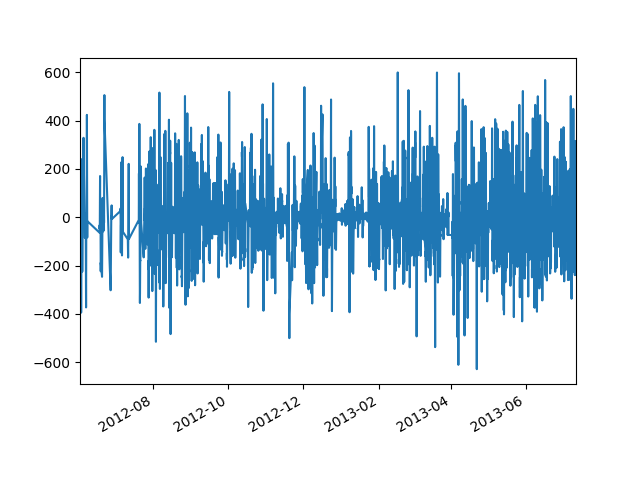

In [35]:
derivatives = pd.Series(hist_deriv)
plt.figure()
derivatives.plot()

In [36]:
derivatives

2012-06-02 00:00:00     25.679608
2012-06-02 01:00:00     54.324537
2012-06-02 02:00:00     50.768830
2012-06-02 03:00:00     39.257192
2012-06-02 04:00:00      5.015154
2012-06-02 05:00:00    -46.033807
2012-06-02 06:00:00    -65.712651
2012-06-02 07:00:00      7.252080
2012-06-02 08:00:00    107.252080
2012-06-02 09:00:00    207.252080
2012-06-02 10:00:00    212.668811
2012-06-02 11:00:00    164.106817
2012-06-02 12:00:00    119.973631
2012-06-02 13:00:00    104.452846
2012-06-02 14:00:00    104.258673
2012-06-02 15:00:00    102.959284
2012-06-02 16:00:00     23.878618
2012-06-02 17:00:00    -74.029449
2012-06-02 18:00:00   -174.029449
2012-06-02 19:00:00   -236.376405
2012-06-02 20:00:00   -289.436105
2012-06-02 21:00:00   -354.555678
2012-06-02 22:00:00   -394.914677
2012-06-02 23:00:00   -391.079939
2012-06-03 00:00:00   -290.795789
2012-06-03 01:00:00   -249.204229
2012-06-03 02:00:00   -206.651213
2012-06-03 03:00:00   -168.819103
2012-06-03 04:00:00   -140.501979
2012-06-03 05:

<IPython.core.display.Javascript object>


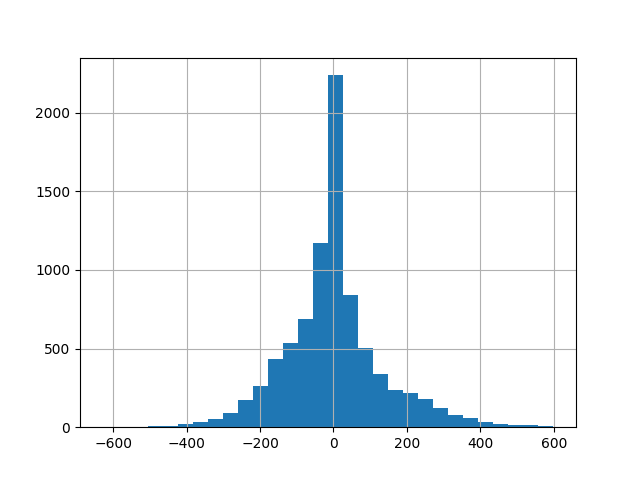

In [37]:
plt.figure()
derivatives.hist(bins=30)

In [38]:
dps, path_dependent_cpts, cpts_patterns, skel_names = pfa.Read_path_dependent_cutpoints(options)
print(dps)

[0, 11, 23]


In [39]:
path_dependent_cpts, dps

({(): 'wide',
  ('widehigh',): 'wide',
  ('widehigh', 'widehigh'): 'wide',
  ('widehigh', 'widelow'): 'wide',
  ('widehigh', 'widemid'): 'wide',
  ('widelow',): 'wide',
  ('widelow', 'widehigh'): 'wide',
  ('widelow', 'widelow'): 'wide',
  ('widelow', 'widemid'): 'wide',
  ('widemid',): 'wide',
  ('widemid', 'widehigh'): 'wide',
  ('widemid', 'widelow'): 'wide',
  ('widemid', 'widemid'): 'wide'},
 [0, 11, 23])

In [40]:
from collections import OrderedDict
import datetime

rolling_errors = OrderedDict()
for dt, error in errors.items():
    if dt <= datetime.datetime.combine(this_date, datetime.datetime.min.time()):
        rolling_errors[dt] = error

<IPython.core.display.Javascript object>


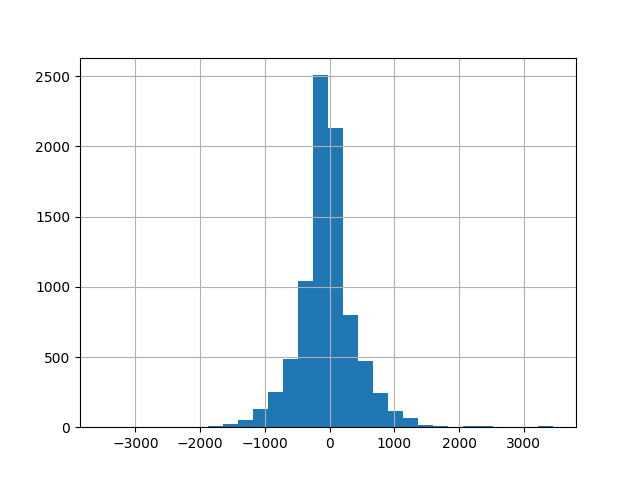

In [41]:
plt.figure()
pd.Series(rolling_errors).hist(bins=30)

In [42]:
import ScenGen.workflow.ProcessError as pe
if options.categorize_by_shape:
    patternDict_historic_forecast = pe.get_patternDict_of_historic_forecast(options, forecasts, hist_deriv)
    Clusters = pe.get_clusterList(options, patternDict_historic_forecast, errors, '4', date1)


  Missing derivative at date/time=2012-06-01 23:00:00
  Missing derivative at date/time=2012-06-05 00:00:00
  Missing derivative at date/time=2012-06-05 23:00:00
  Missing derivative at date/time=2012-06-08 00:00:00
  Missing derivative at date/time=2012-06-17 23:00:00
  Missing derivative at date/time=2012-06-19 00:00:00
  Missing derivative at date/time=2012-06-19 23:00:00
  Missing derivative at date/time=2012-06-22 00:00:00
  Missing derivative at date/time=2012-06-26 23:00:00
  Missing derivative at date/time=2012-06-28 00:00:00
  Missing derivative at date/time=2012-07-04 23:00:00
  Missing derivative at date/time=2012-07-07 00:00:00
  Missing derivative at date/time=2012-07-10 23:00:00
  Missing derivative at date/time=2012-07-12 00:00:00
  Missing derivative at date/time=2012-07-19 23:00:00
  Missing derivative at date/time=2012-07-22 00:00:00
  Missing derivative at date/time=2012-07-23 23:00:00
  Missing derivative at date/time=2012-07-26 00:00:00
  Missing derivative at date

In [43]:
Clusters

[[(-1, -1, -1), (-1, 0, -1), (0, -1, -1), (1, 0, -1), (1, 0, 1), (1, 1, 0)],
 [(-1, -1, 0),
  (-1, 0, 0),
  (-1, 0, 1),
  (0, -1, 0),
  (0, 0, -1),
  (0, 0, 0),
  (0, 0, 1),
  (0, 1, 0),
  (0, 1, 1),
  (1, 0, 0),
  (1, 1, 1),
  (0, -1, 1),
  (-1, 1, 0),
  (-1, -1, 1),
  (-1, 1, 1),
  (1, -1, 0),
  (0, 1, -1)],
 [(1, -1, -1), (1, 1, -1)]]

In [44]:
patternDict = patternDict_historic_forecast

pattern_enough_data=[]                                                      
pattern_not_enough_data=[]                                                  
for pattern in list(patternDict.keys()):                                    
    if len(patternDict[pattern]) > 20 :                                     
        pattern_enough_data.append(pattern)                                 
    else :                                                                  
        pattern_not_enough_data.append(pattern)                             

#Build the Clusters for patterns which have enough data                     
#First build the error forecast dictionary                                  
#Then call the Wets Distance                                                
#In the end call the Markov Clustering algorithm (MCL)                      
eforecast={}                                                                
for pattern in pattern_enough_data :                                        
    eforecast[pattern]={}                                                   
    for dt in patternDict[pattern]:
        if dt.day == scenario_day.day and dt.month == scenario_day.month and dt.year == scenario_day.year:
            continue
        eforecast[pattern][dt]=errors[dt]                                    

if options.wetsdistance_input_picklefile != None:                           
    print ("Reading Wets-Attouch distances from pickle file",options.wetsdistance_input_picklefile)
    import pickle                                                           
    Clusters = pickle.load( open( options.wetsdistance_input_picklefile, "rb"))
else:                                                                       
    print('  Computing Wets-Attouch distances')                             

    cdfs = {}
    options.seg_s = 1/20
    for pattern in pattern_enough_data:                                     
        _, cdf, _, _ = pe.GetPCDF(eforecast[pattern], None, options, '4')      
        cdfs[pattern] = cdf                                                 

    distance_pattern={}                                                     
    for pattern_1 in pattern_enough_data :                                  
        for pattern_2 in pattern_enough_data :                              
            if (pattern_1, pattern_2) in distance_pattern:                  
                continue                                                    
            print("Computing distance between {} and {}".format(pattern_1, pattern_2))
            if pattern_1 == pattern_2:                                      
                distance_pattern[(pattern_1, pattern_2)] = 0                
            distance_pattern[(pattern_1, pattern_2)]=pe.wetsdistance_patterns(options, cdfs[pattern_1], cdfs[pattern_2], '4')
            distance_pattern[(pattern_2, pattern_1)] = distance_pattern[(pattern_1, pattern_2)]

  Computing Wets-Attouch distances
Computing distance between (0, 1, 1) and (0, 1, 1)
Computing distance between (0, 1, 1) and (1, -1, -1)
Computing distance between (0, 1, 1) and (-1, 0, -1)
Computing distance between (0, 1, 1) and (0, 0, 1)
Computing distance between (0, 1, 1) and (1, 0, 1)
Computing distance between (0, 1, 1) and (0, 0, 0)
Computing distance between (0, 1, 1) and (-1, -1, -1)
Computing distance between (0, 1, 1) and (1, 1, 1)
Computing distance between (0, 1, 1) and (-1, -1, 0)
Computing distance between (0, 1, 1) and (1, 1, 0)
Computing distance between (0, 1, 1) and (1, 1, -1)
Computing distance between (0, 1, 1) and (0, 0, -1)
Computing distance between (0, 1, 1) and (1, 0, -1)
Computing distance between (0, 1, 1) and (0, -1, -1)
Computing distance between (0, 1, 1) and (1, 0, 0)
Computing distance between (0, 1, 1) and (-1, 0, 1)
Computing distance between (0, 1, 1) and (-1, 0, 0)
Computing distance between (0, 1, 1) and (0, 1, 0)
Computing distance between (0, 

In [45]:
pe.wetsdistance_patterns(options, cdfs[-1,-1,-1], cdfs[-1,-1,0])

0.039151187033641843

In [46]:
pattern_errors = pd.DataFrame(index=pd.date_range('2000-01-01', '2020-01-01', freq='H'))
for pattern in pattern_enough_data:
    pattern_errors[pattern] = pd.Series(eforecast[pattern])

<IPython.core.display.Javascript object>


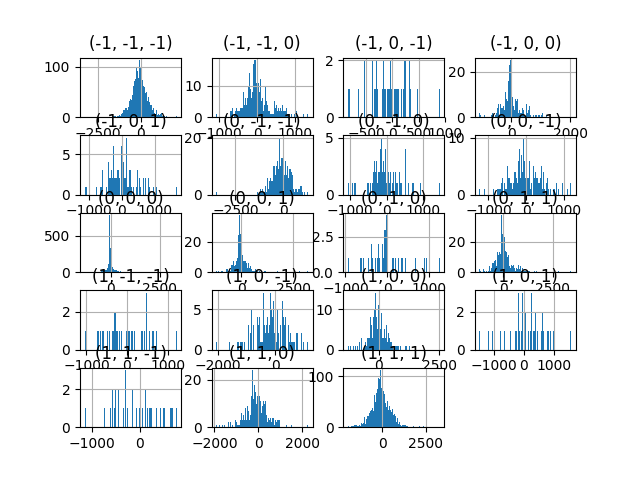

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd384e42748>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fd3841c26d8>]], dtype=object)

In [47]:
pattern_errors[:date_string].hist(bins=100)

In [48]:
import pickle
with open('/home/dominicyang/lolpickle', 'wb') as f:
    pickle.dump((patternDict_historic_forecast, error_series), f)


In [49]:
for val in patternDict_historic_forecast.values():
    print(max(val))

2013-07-11 12:00:00
2013-07-11 00:00:00
2013-07-08 01:00:00
2013-07-10 21:00:00
2013-04-20 07:00:00
2013-07-02 01:00:00
2013-07-11 21:00:00
2013-07-11 09:00:00
2013-07-11 18:00:00
2013-07-11 10:00:00
2013-05-23 00:00:00
2013-07-11 19:00:00
2013-07-10 23:00:00
2013-07-11 22:00:00
2013-07-03 09:00:00
2013-07-03 10:00:00
2013-06-16 00:00:00
2013-07-10 04:00:00
2013-07-11 23:00:00
2013-07-11 20:00:00
2013-07-11 11:00:00
2013-07-09 08:00:00
2013-07-10 03:00:00
2013-03-11 23:00:00
2013-07-09 07:00:00


In [50]:
print(max(error_series.index))

2013-07-10 23:00:00


In [51]:
import gosm.derivative_patterns.derivative_patterns as dp

distance_pattern2 = dp.get_distance_dict(patternDict_historic_forecast, error_series, error_distribution_domain='4')

In [52]:
from gosm.distributions.distributions import UnivariateEpiSplineDistribution

In [53]:
distance_pattern

{((-1, -1, -1), (-1, -1, -1)): 0,
 ((-1, -1, -1), (-1, -1, 0)): 0.039151187033641843,
 ((-1, -1, -1), (-1, 0, -1)): 0.017973248414408338,
 ((-1, -1, -1), (-1, 0, 0)): 0.031481658111179978,
 ((-1, -1, -1), (-1, 0, 1)): 0.039943161702639673,
 ((-1, -1, -1), (0, -1, -1)): 0.0053945007124669431,
 ((-1, -1, -1), (0, -1, 0)): 0.024837778181012515,
 ((-1, -1, -1), (0, 0, -1)): 0.034646628456951267,
 ((-1, -1, -1), (0, 0, 0)): 0.023158565005719001,
 ((-1, -1, -1), (0, 0, 1)): 0.030204515198654081,
 ((-1, -1, -1), (0, 1, 0)): 0.045019043328551833,
 ((-1, -1, -1), (0, 1, 1)): 0.031745271985974322,
 ((-1, -1, -1), (1, -1, -1)): 0.042353645686008246,
 ((-1, -1, -1), (1, 0, -1)): 0.024886551542290136,
 ((-1, -1, -1), (1, 0, 0)): 0.018184807619949894,
 ((-1, -1, -1), (1, 0, 1)): 0.019311891773821643,
 ((-1, -1, -1), (1, 1, -1)): 0.037937031549696548,
 ((-1, -1, -1), (1, 1, 0)): 0.007805420985041861,
 ((-1, -1, -1), (1, 1, 1)): 0.01338709275931782,
 ((-1, -1, 0), (-1, -1, -1)): 0.039151187033641843,


In [54]:
distance_pattern2

{((-1, -1, -1), (-1, -1, -1)): 0,
 ((-1, -1, -1), (-1, -1, 0)): 0.039151187033639179,
 ((-1, -1, -1), (-1, 0, -1)): 0.017973248414411669,
 ((-1, -1, -1), (-1, 0, 0)): 0.031481658111176092,
 ((-1, -1, -1), (-1, 0, 1)): 0.039943161702638341,
 ((-1, -1, -1), (0, -1, -1)): 0.0053945007124679423,
 ((-1, -1, -1), (0, -1, 0)): 0.024837778181010739,
 ((-1, -1, -1), (0, 0, -1)): 0.034646628456951489,
 ((-1, -1, -1), (0, 0, 0)): 0.023158565005714782,
 ((-1, -1, -1), (0, 0, 1)): 0.030204515198650306,
 ((-1, -1, -1), (0, 1, 0)): 0.045019043328551112,
 ((-1, -1, -1), (0, 1, 1)): 0.031745271985971102,
 ((-1, -1, -1), (1, -1, -1)): 0.04235364568600386,
 ((-1, -1, -1), (1, 0, -1)): 0.024886551542293356,
 ((-1, -1, -1), (1, 0, 0)): 0.01818480761994401,
 ((-1, -1, -1), (1, 0, 1)): 0.019311891773824863,
 ((-1, -1, -1), (1, 1, -1)): 0.037937031549697409,
 ((-1, -1, -1), (1, 1, 0)): 0.0078054209850466211,
 ((-1, -1, -1), (1, 1, 1)): 0.013387092759314489,
 ((-1, -1, 0), (-1, -1, -1)): 0.039151187033639179,


In [55]:
distr_1 = UnivariateEpiSplineDistribution([*eforecast[-1,-1,-1].values()], error_distribution_domain='4')
distr_2 = UnivariateEpiSplineDistribution([*eforecast[-1,-1,0].values()], error_distribution_domain='4')

In [56]:
pe.GetPCDF(eforecast[-1,-1,0], None, options, '4')[1]

OrderedDict([(0.0, 0.0),
             (0.050000000000000003, 9.682434447440189e-05),
             (0.10000000000000001, 0.0005380955092427014),
             (0.15000000000000002, 0.0021117143237138892),
             (0.20000000000000001, 0.006561436329498882),
             (0.25, 0.017351154192577236),
             (0.30000000000000004, 0.042886627538851155),
             (0.35000000000000003, 0.10057012638258439),
             (0.40000000000000002, 0.20713174549866475),
             (0.45000000000000001, 0.36159759750017684),
             (0.5, 0.5368748194781348),
             (0.55000000000000004, 0.692574195555946),
             (0.60000000000000009, 0.8041456520578425),
             (0.65000000000000002, 0.8782094238333835),
             (0.70000000000000007, 0.9269471600956624),
             (0.75, 0.9590189051218412),
             (0.80000000000000004, 0.9793620094437301),
             (0.85000000000000009, 0.9902999791936077),
             (0.90000000000000002, 0.99590540559066

In [57]:
len(forecasts)

8376

In [58]:
dt = datetime.datetime.combine(date1, datetime.time(hour=11))
window = pe.get_forecast_in_category(options, forecasts, forecasts, dt, hist_deriv, new_deriv, Clusters=Clusters)


Number of entries in prewindow : 8352
Number of entries in MW window : 3341

pattern = [-1, 0, 1]
cluster = [(-1, -1, 0), (-1, 0, 0), (-1, 0, 1), (0, -1, 0), (0, 0, -1), (0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 1, 1), (0, -1, 1), (-1, 1, 0), (-1, -1, 1), (-1, 1, 1), (1, -1, 0), (0, 1, -1)]
  Missing derivative at date/time=2012-11-20 00:00:00
  Missing derivative at date/time=2012-07-07 00:00:00
  Missing derivative at date/time=2012-07-26 23:00:00
  Missing derivative at date/time=2012-12-04 00:00:00
  Missing derivative at date/time=2012-07-12 00:00:00
  Missing derivative at date/time=2013-03-10 00:00:00
  Missing derivative at date/time=2012-11-17 23:00:00
  Missing derivative at date/time=2012-06-05 00:00:00
  Missing derivative at date/time=2012-07-10 23:00:00
  Missing derivative at date/time=2012-06-19 23:00:00
  Missing derivative at date/time=2012-10-16 23:00:00
  Missing derivative at date/time=2012-06-22 00:00:00
  Missing derivative at date/time=2012-07-

<IPython.core.display.Javascript object>


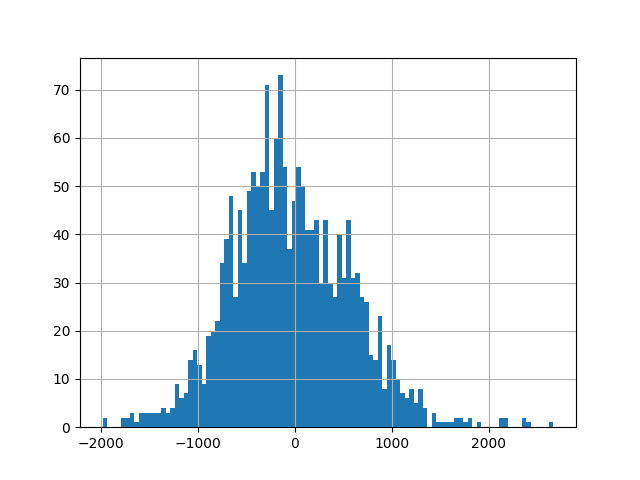

In [59]:
plt.figure()
error_series.loc[window.keys()].hist(bins=100)

<IPython.core.display.Javascript object>


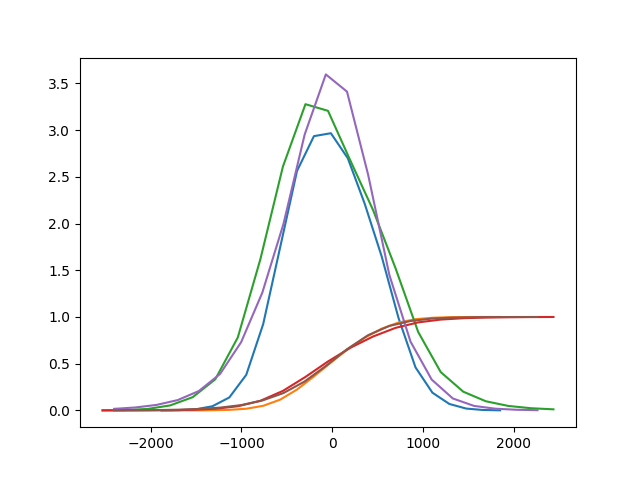

In [60]:
plt.figure()
pd.Series(errors).hist(bins=30)

In [61]:
from collections import OrderedDict
import datetime

labels = []

ErrorScn = OrderedDict()                                        
ErrorProb = OrderedDict()                                       

# Check if 1 hour of dps is missing                             
isMissing = False                                               
for h in dps:                                                   
    dt = datetime.datetime.combine(this_date, datetime.time(h))      
    if dt not in new_forecast:                          
        isMissing = True                                        
        print(dt, ' is missing in newforecast dict')                                                            
if options.categorize_by_vendor_pi_width:                       
    isMissing = False                                           
    for h in dps:                                               
        dt = datetime.datetime.combine(this_date, datetime.time(h))  
        if dt not in working_new_vendor_pi_width:               
            isMissing = True                                    
            print(dt, ' is missing in new vendor pi width dict')
    if isMissing == True:                                       
        print('one or more hours missing for date ', date, '. no scenarios generated for the day')
if hasattr(options, "disable_plots") and not options.disable_plots:
    plt.clf()                                                   
# a0. For each h in dps, get the dictionary of error by moving window
lims = {}  # will save the lims of the day part segments for error correlation probability adjustment
CDFs = {}  # here will the CDFs at each our be saved            

    


In [62]:
for h in dps:                                                   
    lims[h], CDFs[h] = pfa.generate_pathdependent_error_distribution_and_scenarios(
        options, labels, this_date, h, dt, new_forecast, forecasts, errors,
        path_dependent_cpts, cpts_patterns, skel_names,         
        ErrorScn, ErrorProb, dps, None, None,     
        hist_deriv, new_deriv, Clusters,
        None,      
        None)     


Generating error distributions for hour 0

Number of entries in prewindow : 8352
Number of entries in MW window : 3342

pattern = [1, -1, -1]
cluster = [(1, -1, -1), (1, 1, -1)]
  Missing derivative at date/time=2012-11-20 00:00:00
  Missing derivative at date/time=2013-03-10 23:00:00
  Missing derivative at date/time=2012-06-01 23:00:00
  Missing derivative at date/time=2013-04-01 23:00:00
  Missing derivative at date/time=2012-12-16 23:00:00
  Missing derivative at date/time=2012-07-12 00:00:00
  Missing derivative at date/time=2013-03-10 00:00:00
  Missing derivative at date/time=2012-06-19 00:00:00
  Missing derivative at date/time=2012-11-17 23:00:00
  Missing derivative at date/time=2012-06-05 00:00:00
  Missing derivative at date/time=2012-07-10 23:00:00
  Missing derivative at date/time=2012-10-02 00:00:00
  Missing derivative at date/time=2012-06-05 23:00:00
  Missing derivative at date/time=2012-06-22 00:00:00
  Missing derivative at date/time=2012-08-07 00:00:00
  Missing d

In [63]:
lims, CDFs

({0: {(): array([ 0.        ,  0.33868772,  0.66905537,  1.        ])},
  11: {('widehigh',): array([ 0.        ,  0.3476111 ,  0.66406707,  1.        ]),
   ('widelow',): array([ 0.        ,  0.3476111 ,  0.66406707,  1.        ]),
   ('widemid',): array([ 0.        ,  0.3476111 ,  0.66406707,  1.        ])},
  23: {('widehigh',
    'widehigh'): array([ 0.        ,  0.34402816,  0.64795795,  1.        ]),
   ('widehigh',
    'widelow'): array([ 0.        ,  0.34402816,  0.64795795,  1.        ]),
   ('widehigh',
    'widemid'): array([ 0.        ,  0.34402816,  0.64795795,  1.        ]),
   ('widelow',
    'widehigh'): array([ 0.        ,  0.34402816,  0.64795795,  1.        ]),
   ('widelow',
    'widelow'): array([ 0.        ,  0.34402816,  0.64795795,  1.        ]),
   ('widelow',
    'widemid'): array([ 0.        ,  0.34402816,  0.64795795,  1.        ]),
   ('widemid',
    'widehigh'): array([ 0.        ,  0.34402816,  0.64795795,  1.        ]),
   ('widemid',
    'widelow'): arr

In [64]:
xs, ys = [*CDFs[0].keys()], [*CDFs[0].values()]

In [133]:
np.interp(0.1, ys, xs)

0.338687719422342

In [134]:
ErrorScn

OrderedDict([((), array([-811.56020222,  -20.07565387,  826.65811365])),
             (('widelow',),
              array([-1082.5593496 ,   -57.77911101,  1103.99468054])),
             (('widemid',),
              array([-1082.5593496 ,   -57.77911101,  1103.99468054])),
             (('widehigh',),
              array([-1082.5593496 ,   -57.77911101,  1103.99468054])),
             (('widemid', 'widelow'),
              array([-1149.65543015,   -52.29760325,   892.81296289])),
             (('widehigh', 'widehigh'),
              array([-1149.65543015,   -52.29760325,   892.81296289])),
             (('widemid', 'widemid'),
              array([-1149.65543015,   -52.29760325,   892.81296289])),
             (('widelow', 'widelow'),
              array([-1149.65543015,   -52.29760325,   892.81296289])),
             (('widelow', 'widehigh'),
              array([-1149.65543015,   -52.29760325,   892.81296289])),
             (('widehigh', 'widemid'),
              array([-1149.6554301

In [135]:
def stringify(node):
    return "Node(power:{},hour:{})".format(node.power, node.hour)

In [136]:
ndps = len(dps)-1                                                           
nlist = []  # list to save all the nodes in the tree                        
leafs = []  # list to save all the leafs of the tree

wf = forecasts
date = this_date
futfat = [None]  # list that contains the future parents.                   
# A parent is a node that splits in order to generate more than one scenario.
for i in range(ndps):  # loop over the parts of the day                     
    for q in range(len(futfat)):  # loop over the future parents            
        parent = futfat.pop()  # we take the first parent on the list       
        t1 = dps[i]                                                         
        t2 = dps[i+1]                                                       

        # forecasted load for date and initial time                         
        lx = wf[datetime.datetime.combine(date, datetime.time(t1))]         

        # initialization of the probability of each scenario                
        prx = 1                                                             

        # initialization of the scenario number                             
        sx = 0                                                              
        hx = 0  # initialization of the hour                                

        if i == 0: # first hour of the day                                  
            t1 = -1                                                         

            for path in path_dependent_cpts:                                
                # This skips over any path that is not the empty path       
                if len(path) != 0:                                          
                    continue                                                
                for nextpath in path_dependent_cpts:                        
                    if len(nextpath) != 1:  # these have the result from hour 0 in them.
                        continue                                            
                    for s in range(len(ErrorScn[nextpath])):                
                        # s is is the index of node at time tf              

                        cutpoint_set = path_dependent_cpts[path]            
                        r = skel_names[cutpoint_set].index(nextpath[-1])    
                        # r is is the index of node at time ti              
                        snode = parent                                      
                        if ErrorProb[nextpath][s] == 0.0 or ErrorProb[path][r] == 0.0:
                            # do not follow paths with no prob mass         
                            continue                                        
                        for hr in range(t1+1, t2+1):  # here we interpolate the points between the two dps
                            error = ErrorScn[path][r] * (t2-hr) + ErrorScn[nextpath][s] * (hr-t1)
                            error /= (t2-t1)                                
                            ld = wf[datetime.datetime.combine(date, datetime.time(hr))] + error
                            pr = ErrorProb[nextpath][s]*ErrorProb[path][r]  
                            # prx is the probability of the branch parent   
                            fa = snode                                      
                            dy = date                                       
                            dp = i                                          
                            sc = [r, s]                                     
                            nd = pfa.Node(ld, pr, fa, hr, dy, dp, sc, nextpath +
                                      (skel_names[path_dependent_cpts[nextpath]][s],))
                            nlist.append(nd)                                
                            if fa != None:                                  
                                fa.children.append(nd)
                            snode = nd                                      
                        futfat.insert(0,snode)                              

        if parent != None:  # if parent == None it means we are in the first hour of the day
            hx = parent.hour                                                
            dx = parent.day                                                 
            lx = parent.power                                               
            prx = parent.prob                                               
            sx = parent.scn                                                 
            pathx = parent.path                                             

            for s in range(len(ErrorScn[pathx])):                           
                snode = parent                                              
                if ErrorProb[pathx][s] == 0.0:  # do not follow paths with no prob mass
                    continue                                                
                for hr in range(t1+1, t2+1):                                
                    # Debug for when tf = ti+1 GCS Oct 2014                 
                    error2 = (lx-wf[datetime.datetime.combine(              
                              date, datetime.time(hx))])                    

                    error = error2*(t2-hr) + ErrorScn[pathx][s] * (hr-t1)   
                    error /= (t2-t1)                                        
                    ld = wf[datetime.datetime.combine(date, datetime.time(hr))] + error
                    pr = ErrorProb[pathx][s]*prx  # prx is the probability of the branch parent
                    fa = snode                                              
                    dy = date                                               
                    dp = i                                                  
                    sc = s                                                  
                    nd = pfa.Node(ld, pr, fa, hr, dy, dp, sc, pathx + (skel_names[path_dependent_cpts[pathx]][s],))
                    nlist.append(nd)                                        
                    if fa != None:                                          
                        fa.children.append(nd)                              
                    snode = nd                                              
                futfat.insert(0, snode)
pfa.Node.__str__ = stringify
nlist.sort(key=lambda x:x.hour)
[str(node) for node in nlist]

['Node(power:2434.8565354976527,hour:0)',
 'Node(power:2520.254888713462,hour:0)',
 'Node(power:2617.0693713427595,hour:0)',
 'Node(power:3160.384038152717,hour:0)',
 'Node(power:3245.782391368527,hour:0)',
 'Node(power:3342.5968739978243,hour:0)',
 'Node(power:3936.556658377088,hour:0)',
 'Node(power:4021.9550115928973,hour:0)',
 'Node(power:4118.769494222195,hour:0)',
 'Node(power:2200.2732732159416,hour:1)',
 'Node(power:2371.0699796475615,hour:1)',
 'Node(power:2564.6989449061557,hour:1)',
 'Node(power:2859.843730175091,hour:1)',
 'Node(power:3030.640436606711,hour:1)',
 'Node(power:3224.2694018653056,hour:1)',
 'Node(power:3565.455203106337,hour:1)',
 'Node(power:3736.251909537957,hour:1)',
 'Node(power:3929.880874796552,hour:1)',
 'Node(power:2006.6900109342305,hour:2)',
 'Node(power:2262.8850705816603,hour:2)',
 'Node(power:2553.3285184695524,hour:2)',
 'Node(power:2600.303422197465,hour:2)',
 'Node(power:2856.4984818448947,hour:2)',
 'Node(power:3146.941929732787,hour:2)',
 'No

In [137]:
print('purging duplicate nodes..')                                          
counter = 0                                                                 
changed = 1                                                                 
nlist.sort(key=lambda node: node.hour)  # sort the nodes by hour            
while changed == 1:                                                         
    changed = 0                                                             
    removelist = []                                                         
    addlist = []                                                            
    for node1 in nlist:                                                     
        for node2 in nlist:                                                 
            if (node1.parent != node2.parent or
               node1.power != node2.power or
               node1.hour != node2.hour or
               node1 == node2):
                continue                                                    
            changed = 1                                                     
            merge_node = Node(node1.power, node1.prob + node2.prob,         
                              node1.parent, node1.hour, node1.day, node1.dp, node1.scn, node1.path)
            for child in node1.children:                                    
                merge_node.children.append(child)                           
                child.parent = merge_node                                   
            for child in node2.children:                                    
                merge_node.children.append(child)                           
                child.parent = merge_node                                   
            removelist.append(nlist.index(node1))                           
            removelist.append(nlist.index(node2))                           
            addlist.append(merge_node)                                      
            counter += 1                                                    
            break                                                           
        if changed == 1:                                                    
            break                                                           
    removelist = list(set(removelist))                                      
    removelist.sort()                                                       
    removelist.reverse()                                                    
    for i in removelist:                                                    
        nlist.pop(i)                                                        
    for node in addlist:                                                    
        nlist.append(node)                                                  
    nlist.sort(key= lambda node: node.hour) # sort the nlist again          
if counter > 0:                                                             
    print(counter,' duplicate nodes deleted so there will be fewer scenarios.')
leaves = [node for node in nlist if node.children == []]
leaves

purging duplicate nodes..


In [138]:
def scenario_from_leaf(leaf):
    power_forecast = []
    current_node = leaf
    while current_node.parent is not None:
        power_forecast.append(current_node.power)
        current_node = current_node.parent
    power_forecast.append(current_node.power)
    power_forecast.reverse()
    return power_forecast
scenarios = [scenario_from_leaf(leaf) for leaf in leaves]

<IPython.core.display.Javascript object>


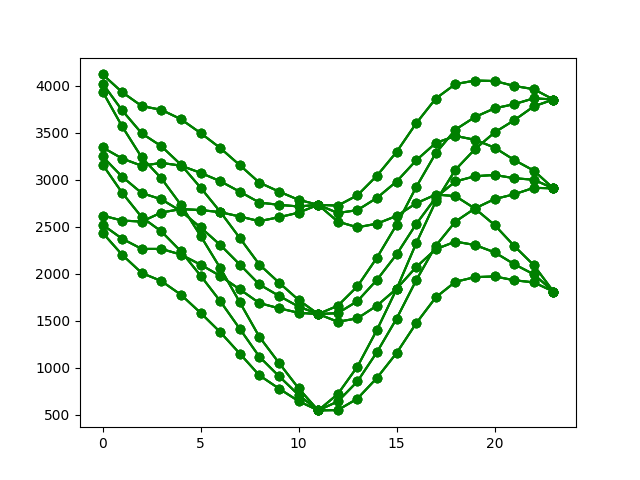

In [139]:
plt.figure()
for scenario in scenarios:
    scenario = [value if value >= 0 else 0 for value in scenario]
    plt.plot(scenario, color='green', marker='o')

In [140]:
plt.figure()
forecast_of_day = forecast_series[error_series.index.date == this_date]
for scenario in scenarios:
    plt.plot(forecast_of_day-scenario, color='r')

<IPython.core.display.Javascript object>

IndexError: boolean index did not match indexed array along dimension 0; dimension is 8376 but corresponding boolean dimension is 8396

<IPython.core.display.Javascript object>


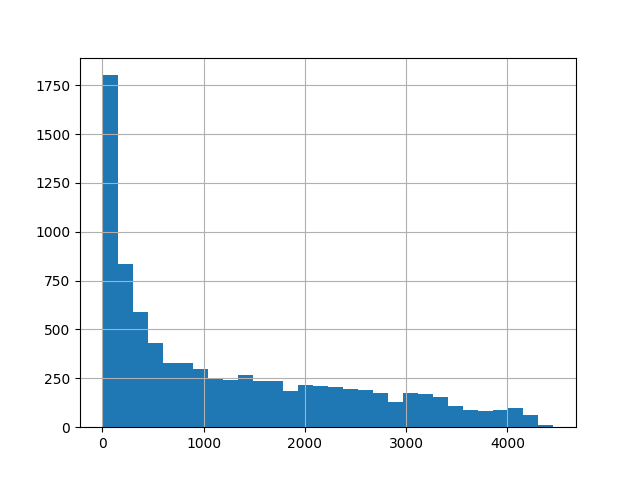

Max date 2013-07-11 23:00:00


In [141]:
historic_forecasts = pd.Series(forecasts)
plt.figure()
historic_forecasts.hist(bins=30)
print("Max date", max(historic_forecasts.index))

In [142]:
print(path_dependent_cpts)
print(cpts_patterns)

{('widelow',): 'wide', ('widemid', 'widelow'): 'wide', ('widehigh', 'widehigh'): 'wide', ('widemid',): 'wide', ('widemid', 'widemid'): 'wide', ('widelow', 'widelow'): 'wide', ('widehigh',): 'wide', ('widelow', 'widehigh'): 'wide', (): 'wide', ('widehigh', 'widemid'): 'wide', ('widehigh', 'widelow'): 'wide', ('widelow', 'widemid'): 'wide', ('widemid', 'widehigh'): 'wide'}
{'wwide': [0.0, 0.05, 0.5, 0.95, 1.0], 'wwwide': [0.0, 0.01, 0.5, 0.99, 1.0], 'ide': [0.0, 0.3, 0.7, 1.0], 'diverse': [0.0, 0.2, 0.5, 0.8, 1.0], 'wideskew1': [0.0, 0.05, 0.85, 1.0], 'uni4': [0.0, 0.25, 0.5, 0.75, 1.0], 'uni10': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'uni5': [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], 'meanonly': [0.0, 1.0], 'uni3': [0.0, 0.33, 0.67, 1.0], 'extreme': [0.0, 0.01, 0.5, 0.99, 1.0], 'wide': [0.0, 0.1, 0.9, 1.0], 'quick': [0.0, 0.5, 1.0], 'wideskew2': [0.0, 0.1, 0.95, 1.0]}


In [143]:
import ScenGen.workflow.ProcessError as pe

dt1 = datetime.datetime.combine(this_date, datetime.time(hour=dps[0]))
dt2 = datetime.datetime.combine(this_date, datetime.time(hour=dps[1]))
dt3 = datetime.datetime.combine(this_date, datetime.time(hour=dps[2]))

window_1 = pe.get_forecast_in_window(options, dt1, forecasts, forecasts)
window_1 = pe.get_forecast_by_shape(options, window_1, hist_deriv, new_deriv, Clusters, dt1)
window_2 = pe.get_forecast_in_window(options, dt2, forecasts, forecasts)
window_2 = pe.get_forecast_by_shape(options, window_2, hist_deriv, new_deriv, Clusters, dt2)
window_3 = pe.get_forecast_in_window(options, dt3, forecasts, forecasts)
window_3 = pe.get_forecast_by_shape(options, window_3, hist_deriv, new_deriv, Clusters, dt3)



Number of entries in prewindow : 8352
Number of entries in MW window : 3342

pattern = [1, -1, -1]
cluster = [(1, -1, -1), (1, 1, -1)]
  Missing derivative at date/time=2012-12-16 23:00:00
  Missing derivative at date/time=2012-07-26 23:00:00
  Missing derivative at date/time=2012-06-05 23:00:00
  Missing derivative at date/time=2012-10-02 00:00:00
  Missing derivative at date/time=2012-07-10 23:00:00
  Missing derivative at date/time=2013-03-10 23:00:00
  Missing derivative at date/time=2012-06-19 00:00:00
  Missing derivative at date/time=2012-10-02 23:00:00
  Missing derivative at date/time=2012-08-07 23:00:00
  Missing derivative at date/time=2012-11-17 23:00:00
  Missing derivative at date/time=2012-06-17 23:00:00
  Missing derivative at date/time=2013-03-10 00:00:00
  Missing derivative at date/time=2013-04-01 23:00:00
  Missing derivative at date/time=2012-06-05 00:00:00
  Missing derivative at date/time=2012-07-19 23:00:00
  Missing derivative at date/time=2012-11-20 00:00:00


Window [1304.0, 4176.0]


<IPython.core.display.Javascript object>


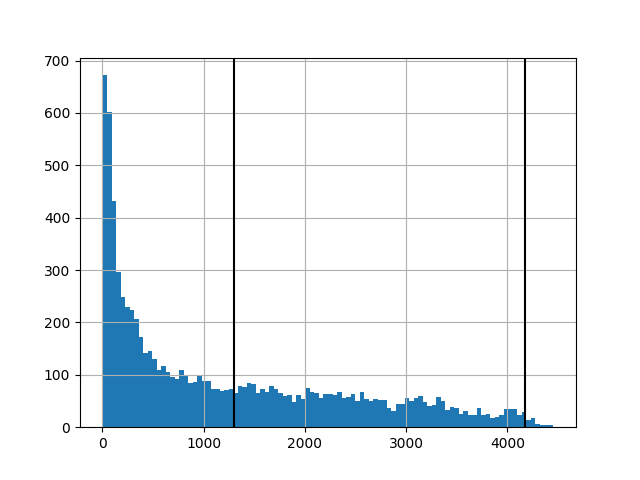

In [144]:
def plot_window(window):
    minimum = min(window.values())
    maximum = max(window.values())
    print("Window [{}, {}]".format(minimum, maximum))
    plt.figure()
    historic_forecasts.hist(bins=100)
    plt.axvline(minimum, color='black')
    plt.axvline(maximum, color='black')
plot_window(window_1)

Window [715.0, 2916.0]


<IPython.core.display.Javascript object>


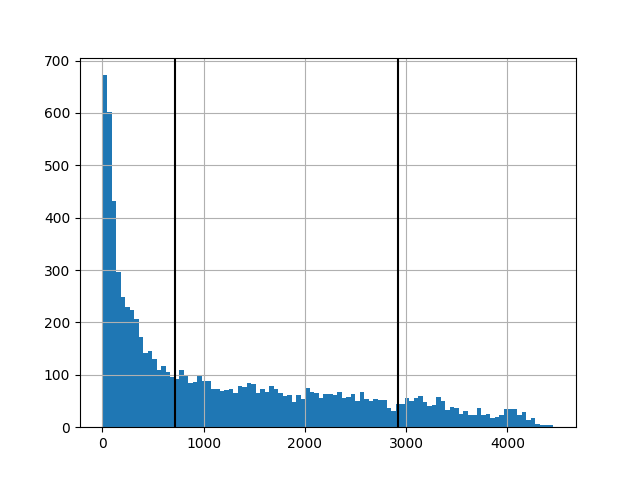

In [145]:
plot_window(window_2)

Window [1276.0, 4455.0]


<IPython.core.display.Javascript object>


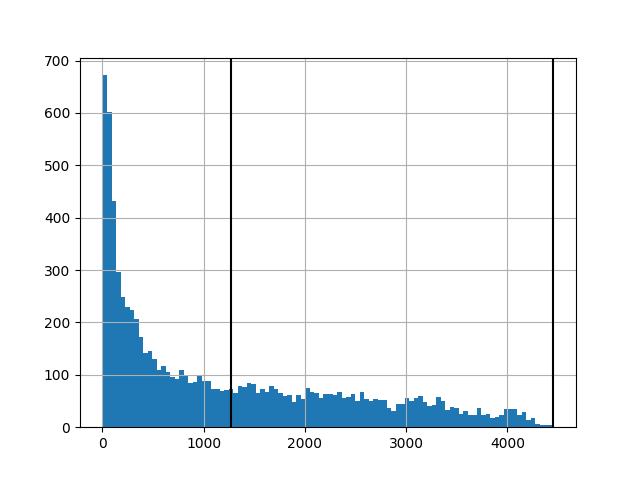

In [146]:
plot_window(window_3)

In [176]:
error_1 = {dt: errors[dt] for dt in window_1}
error_2 = {dt: errors[dt] for dt in window_2}
error_3 = {dt: errors[dt] for dt in window_3}

/home/dominicyang/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


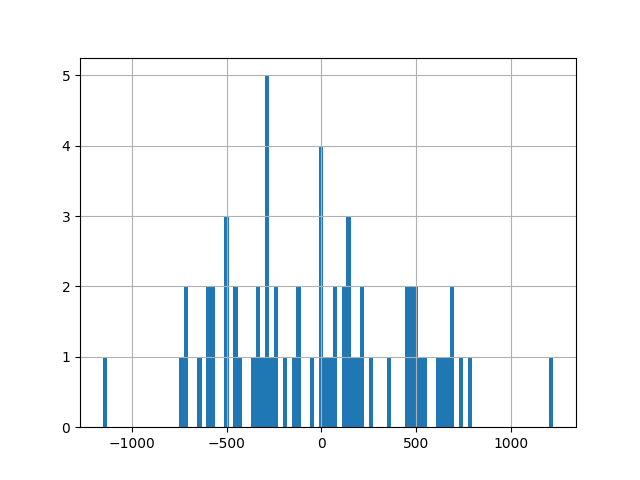

In [177]:
error_series_1 = pd.Series(error_1)
error_series_2 = pd.Series(error_2)
error_series_3 = pd.Series(error_3)

plt.figure()
error_series_1.hist(bins=100)

/home/dominicyang/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


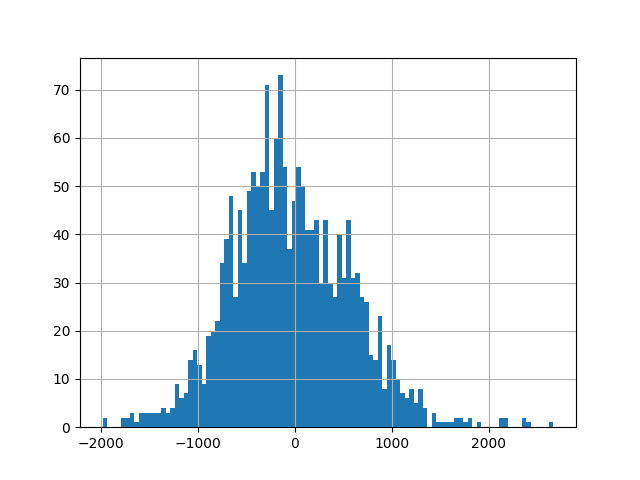

In [178]:
plt.figure()
error_series_2.hist(bins=100)
with open('/home/dominicyang/lolpickle', 'wb') as f:
    pickle.dump(error_series_2, f)

In [175]:
print(error_series_2)

0       1890.0
1       -723.0
2         35.0
3       1024.0
4      -1003.0
5        384.0
6       1070.0
7       -656.0
8       -390.0
9        -31.0
10      -120.0
11      -158.0
12      -478.0
13       130.0
14     -1760.0
15      -210.0
16      -745.0
17      2173.0
18       835.0
19      1018.0
20       571.0
21       263.0
22      -472.0
23       456.0
24      -251.0
25      -901.0
26      1674.0
27      1200.0
28      -505.0
29      -418.0
         ...  
1711    -110.0
1712      42.0
1713    -638.0
1714     540.0
1715     -89.0
1716     -86.0
1717    -626.0
1718      12.0
1719    -508.0
1720    -179.0
1721    1035.0
1722    -657.0
1723     472.0
1724     372.0
1725    -187.0
1726    -479.0
1727      66.0
1728     -47.0
1729    -306.0
1730     482.0
1731    -145.0
1732     757.0
1733    -330.0
1734     206.0
1735    -699.0
1736    1278.0
1737     451.0
1738     732.0
1739     144.0
1740     784.0
Length: 1741, dtype: float64


<IPython.core.display.Javascript object>


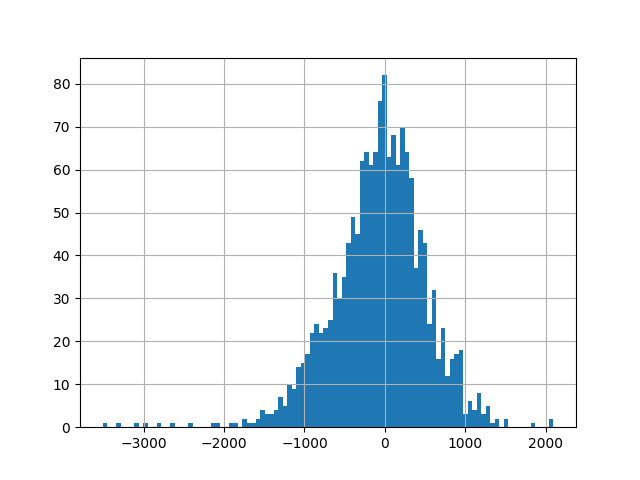

In [150]:
plt.figure()
error_series_3.hist(bins=100)

In [151]:
import ScenGen.workflow.EpiModel as em
spline_1, alpha_1, beta_1 = em.FitDistribution(error_1, options, options.error_distribution_domain)
print(alpha_1, beta_1)

-1878.94730599 1849.06670897


In [152]:
spline_2, alpha_2, beta_2 = em.FitDistribution(error_2, options, options.error_distribution_domain)
spline_3, alpha_3, beta_3 = em.FitDistribution(error_3, options, options.error_distribution_domain)

spline_1.pprint()

3 Set Declarations
    a_index : Dim=0, Dimen=1, Size=20, Domain=None, Ordered=False, Bounds=(1, 20)
        [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
    et_index : Dim=0, Dimen=1, Size=67, Domain=None, Ordered=False, Bounds=(0, 66)
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66]
    tau_index : Dim=0, Dimen=1, Size=20, Domain=None, Ordered=False, Bounds=(1, 20)
        [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

4 Param Declarations
    N : Size=1, Index=None, Domain=PositiveReals, Default=None, Mutable=False
        Key  : Value
        None :    20
    delta : Size=1, Index=None, Domain=PositiveReals, Default=None, Mutable=False
        Key  : Value
        None :  0.05
    et : Size=67, Index=et_index, Domai

In [153]:
import ScenGen.workflow.segmenter as segmenter

pdf_1, cdf_1 = segmenter.PCDF(spline_1, options.seg_N, 0.001)
pdf_2, cdf_2 = segmenter.PCDF(spline_2, options.seg_N, 0.001)
pdf_3, cdf_3 = segmenter.PCDF(spline_3, options.seg_N, 0.001)


def plot_pdf(pdf_dict, alpha, beta, label):
    rescaled = {(x*(beta - alpha) + alpha):pdf_dict[x]/(beta - alpha) for x in pdf_dict}
    xs = list(rescaled.keys())
    ys = [rescaled[x] for x in xs]
    plt.plot(xs, ys, label=label)


plt.figure()
plot_pdf(pdf_1, alpha_1, beta_1, 'hour 0')
plot_pdf(pdf_2, alpha_2, beta_2, 'hour 11')
plot_pdf(pdf_3, alpha_3, beta_3, 'hour 23')
plt.legend()

<IPython.core.display.Javascript object>

In [154]:
def plot_normalized_pdf(pdf_dict, label):
    xs = list(pdf_dict.keys())
    ys = [pdf_dict[x] for x in xs]
    plt.plot(xs, ys, label=label)

plt.figure()
plot_normalized_pdf(pdf_1, 'hour 0')
plot_normalized_pdf(pdf_2, 'hour 11')
plot_normalized_pdf(pdf_3, 'hour 23')
plt.legend()

<IPython.core.display.Javascript object>

In [155]:
print_options(options)

DayClone : CopyLast
L1Linf_solver : gurobi
L2Norm_solver : gurobi
MSSim_Ruc_solver_tee : False
MSSim_Sced_solver_tee : False
MSSim_adjust_load : False
MSSim_adjust_renewables : False
MSSim_initial_conditions_from_file : None
MSSim_num_days : 1
MSSim_perfect_updates_scenarios : False
MSSim_plotCharts : False
MSSim_plot_CommitmentCharts : False
MSSim_plot_adjusted_scenarios : False
MSSim_pprint_RUC : False
MSSim_run_ID_deterministic_for_everymodel : False
MSSim_start_date : None
MSSim_use_adjusted_scenarios : False
MSSim_use_same_model_for_stage2 : False
MSSim_write_RUC_lp_files : False
MSSimulator_RUC_TimeLimit : None
MSSimulator_mipgap : 0.1
actual_outage_scenario : 0
actual_wind_scenario : 0
actuals_input_filename : 2012-2013_BPA_forecasts_actuals.csv
alpha_prediction_interval : None
categorize_by_derivative_behaviour : False
categorize_by_first_difference_behaviour : False
categorize_by_shape : True
categorize_by_vendor_agreement : False
categorize_by_vendor_pi_width : False
commitme

In [156]:
sys.path.append('/home/domyang/software/prescient')
import gosm.distributions.distributions as distributions

epispline_1 = distributions.UnivariateEpiSplineDistribution(error_1, error_distribution_domain='4',
                seg_N=20, seg_kappa=100, non_negativity_constraint_distributions=0,
                probability_constraint_of_distributions=1, nonlinear_solver='ipopt')

epispline_2 = distributions.UnivariateEpiSplineDistribution(error_2, error_distribution_domain='4',
                seg_N=20, seg_kappa=100, non_negativity_constraint_distributions=0,
                probability_constraint_of_distributions=1, nonlinear_solver='ipopt')

epispline_3 = distributions.UnivariateEpiSplineDistribution(error_3, error_distribution_domain='4',
                seg_N=20, seg_kappa=100, non_negativity_constraint_distributions=0,
                probability_constraint_of_distributions=1, nonlinear_solver='ipopt')

print(epispline_1.alpha, epispline_1.beta)

-1878.94730599 1849.06670897


In [157]:
cutpoints = [0,0.3,0.7,1]

def skeleton_points(distribution, cutpoints):
    xs = [distribution.cdf_inverse(y, cdf_inverse_tolerance=1e-4, cdf_inverse_max_refinements=10) for y in cutpoints]
    points = []
    for i, (a, b) in enumerate(zip(xs, xs[1:])):
        x = distribution.region_expectation((a,b))
        points.append(x/(cutpoints[i+1] - cutpoints[i]))
    return xs, points

inverses, skeleton_1 = skeleton_points(epispline_1, [0,0.3,0.7,1])
inverses, skeleton_1

([-1878.9473059851239,
  -282.89130583237647,
  235.53564312234795,
  1849.0667089701983],
 [-554.7078380022656, -27.84030806338062, 541.9352288782602])

In [158]:
xs = np.linspace(epispline_1.alpha, epispline_1.beta, 100)
cdfs = [epispline_1.cdf(x) for x in xs]
np.interp(cutpoints, cdfs, (xs - epispline_1.alpha) / (epispline_1.beta - epispline_1.alpha)), np.interp(cutpoints, list(cdf_1.values()), list(cdf_1))

(array([ 0.        ,  0.42806886,  0.56719561,  1.        ]),
 array([ 0.        ,  0.42809664,  0.56716987,  0.99586478]))

In [159]:
[(x - epispline_1.alpha) / (epispline_1.beta - epispline_1.alpha) for x in inverses]

[0.0, 0.42812500000000003, 0.56718750000000007, 1.0]

In [160]:
def plot_pdf_2():
    xs1 = np.linspace(epispline_1.alpha, epispline_1.beta, 100)
    ys1 = [epispline_1.pdf(x) for x in xs1]
    
    xs2 = np.linspace(epispline_2.alpha, epispline_2.beta, 100)
    ys2 = [epispline_2.pdf(x) for x in xs1]
    
    xs3 = np.linspace(epispline_3.alpha, epispline_3.beta, 100)
    ys3 = [epispline_3.pdf(x) for x in xs1]
    
    fig, ax = plt.subplots()
    ax.plot(xs1, ys1, label='hour 0')
    ax.plot(xs2, ys2, label='hour 11')
    ax.plot(xs3, ys3, label='hour 23')
    plt.legend()

plot_pdf_2()

/home/dominicyang/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>

In [161]:
def plot_normalized_pdf_2():
    xs1 = np.linspace(0, 1, 100)
    ys1 = [epispline_1._normalized_pdf(x) for x in xs1]
    
    xs2 = np.linspace(0, 1, 100)
    ys2 = [epispline_2._normalized_pdf(x) for x in xs1]
    
    xs3 = np.linspace(0, 1, 100)
    ys3 = [epispline_3._normalized_pdf(x) for x in xs1]
    
    fig, ax = plt.subplots()
    ax.plot(xs1, ys1, label='hour 0')
    ax.plot(xs2, ys2, label='hour 11')
    ax.plot(xs3, ys3, label='hour 23')
    plt.legend()

plot_normalized_pdf_2()

/home/dominicyang/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>

In [162]:
def plot_limits(limits, alpha, beta):
    for x in limits:
        plt.axvline(x=(x*(beta-alpha)+alpha), color='black')

In [163]:
epispline_1._cdf_inverse([0, 0.3, 0.7, 1])

array([ 0.        ,  0.42806883,  0.56719561,  0.99631603])

In [164]:
plt.figure()
lims1,CDF1 = pfa.get_pathdependent_PCDF_and_cpts_prob(options, spline_1, alpha_1,
                                                    beta_1, [], 0,
                                                    path_dependent_cpts,
                                                    cpts_patterns,
                                                    skel_names, dps)
lims2,CDF2 = pfa.get_pathdependent_PCDF_and_cpts_prob(options, spline_2, alpha_2,
                                                    beta_2, [], 11,
                                                    path_dependent_cpts,
                                                    cpts_patterns,
                                                    skel_names, dps)
lims3,CDF3 = pfa.get_pathdependent_PCDF_and_cpts_prob(options, spline_3, alpha_3,
                                                    beta_3, [], 23,
                                                    path_dependent_cpts,
                                                    cpts_patterns,
                                                    skel_names, dps)

plt.axhline(0.1, color='black')
plt.axhline(0.9, color='black')

plot_limits(lims1[()], alpha_1, beta_1)
plot_limits(lims2[('widehigh',)], alpha_2, beta_2)
plot_limits(lims3[('widelow','widelow')], alpha_3, beta_3)

/home/dominicyang/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>

In [165]:
np.interp([0, 0.1, 0.9, 1], [*CDF1.values()], [*CDF1.keys()])

array([ 0.        ,  0.33868772,  0.66905537,  0.99839759])

In [166]:
lims1, lims2, lims3

({(): array([ 0.        ,  0.33868772,  0.66905537,  1.        ])},
 {('widehigh',): array([ 0.        ,  0.3476111 ,  0.66406707,  1.        ]),
  ('widelow',): array([ 0.        ,  0.3476111 ,  0.66406707,  1.        ]),
  ('widemid',): array([ 0.        ,  0.3476111 ,  0.66406707,  1.        ])},
 {('widehigh',
   'widehigh'): array([ 0.        ,  0.34402816,  0.64795795,  1.        ]),
  ('widehigh',
   'widelow'): array([ 0.        ,  0.34402816,  0.64795795,  1.        ]),
  ('widehigh',
   'widemid'): array([ 0.        ,  0.34402816,  0.64795795,  1.        ]),
  ('widelow',
   'widehigh'): array([ 0.        ,  0.34402816,  0.64795795,  1.        ]),
  ('widelow',
   'widelow'): array([ 0.        ,  0.34402816,  0.64795795,  1.        ]),
  ('widelow',
   'widemid'): array([ 0.        ,  0.34402816,  0.64795795,  1.        ]),
  ('widemid',
   'widehigh'): array([ 0.        ,  0.34402816,  0.64795795,  1.        ]),
  ('widemid',
   'widelow'): array([ 0.        ,  0.34402816,  

In [167]:
print(alpha_1, beta_1)
print(alpha_2, beta_2)
print(alpha_3, beta_3)

-1878.94730599 1849.06670897
-2529.98206737 2436.79883934
-2402.24706551 2261.21914672


In [168]:
import ScenGen.workflow.EpiScenarios as EpiScenarios
scen1, prob1 = EpiScenarios.CalculateScenarios(spline_1,
                                               options.seg_N,
                                               lims1[()],
                                               alpha_1, beta_1)
scen2, prob2 = EpiScenarios.CalculateScenarios(spline_2,
                                               options.seg_N,
                                               lims2[('widehigh',)],
                                               alpha_2, beta_2)
scen3, prob3 = EpiScenarios.CalculateScenarios(spline_3,
                                               options.seg_N,
                                               lims3[('widelow','widelow')],
                                               alpha_3, beta_3)
plt.figure()
plot_pdf(pdf_1, alpha_1, beta_1, 'hour 0')
plot_pdf(pdf_2, alpha_2, beta_2, 'hour 11')
plot_pdf(pdf_3, alpha_3, beta_3, 'hour 23')
plot_limits(lims1[()], alpha_1, beta_1)
plot_limits(lims2[('widehigh',)], alpha_2, beta_2)
plot_limits(lims3[('widelow','widelow')], alpha_3, beta_3)

plt.legend()

/home/dominicyang/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>

In [169]:
scen1, scen2, scen3

(array([-811.56020222,  -20.07565387,  826.65811365]),
 array([-1082.5593496 ,   -57.77911101,  1103.99468054]),
 array([-1149.65543015,   -52.29760325,   892.81296289]))

In [170]:
forecasts[dt1] + scen1, forecasts[dt2] + scen2, forecasts[dt3] + scen3

(array([ 2457.43979778,  3248.92434613,  4095.65811365]),
 array([  545.4406504 ,  1570.22088899,  2731.99468054]),
 array([ 1809.34456985,  2906.70239675,  3851.81296289]))

In [171]:
plt.figure()
plt.plot(xs, list(cdfs.values()), label='prescient')
plt.plot(xs, cdfs_2, label='gosm')
plt.legend()

/home/dominicyang/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>

AttributeError: 'list' object has no attribute 'values'

In [ ]:
spline, alpha, beta = em.FitDistribution(error_1, options, dom='4')
pdfs, cdfs = segmenter.PCDF(spline, 20, 0.01)

plt.figure()
plt.plot(list(pdfs.keys()), list(pdfs.values()), label='prescient')

epispline_1 = distributions.UnivariateEpiSplineDistribution(error_1, dom='4',
                seg_N=20, seg_kappa=100, non_negativity_constraint_distributions=0,
                probability_constraint_of_distributions=1, nonlinear_solver='ipopt')
xs = list(pdfs.keys())
pdfs_2 = [epispline_1._normalized_pdf(x) for x in xs]
cdfs_2 = [epispline_1._normalized_cdf(x) for x in xs]
plt.plot(xs, pdfs_2, label='gosm')
plt.legend()